In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib notebook

In [9]:
lc_list = numpy.load('lc_list.npy')
p = numpy.load('periods_arr.npy')
X_h = numpy.load('X_harmonics.npy')
lbls_all = numpy.load('lbls_all.npy')
nof_objects = len(lc_list)

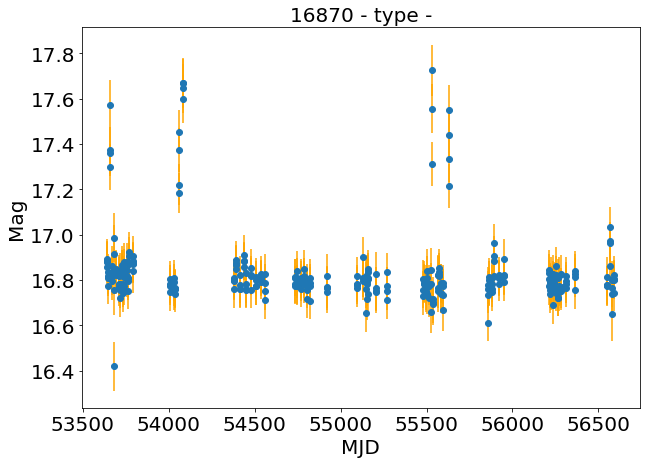

In [3]:
idx = numpy.random.choice(numpy.arange(nof_objects))
lc = lc_list[idx]
mag = lc[:,0]
dmag = lc[:,2]
t = lc[:,1]
plt.figure(figsize = (10,7))
plt.errorbar(x=t,y=mag, yerr=dmag,fmt='o', ecolor='orange' )
ttl = '{} - type -'.format(idx)
plt.title(ttl, fontsize = 20)
plt.xlabel('MJD',fontsize = 20)
plt.ylabel('Mag',fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

0.655600095297906


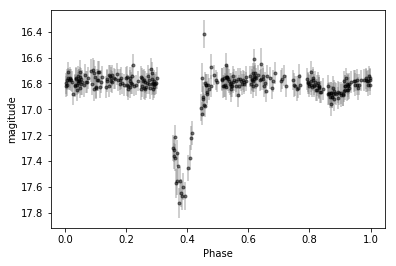

In [4]:
period = p[idx]
print(period)
phase = (t /period /2) % 1
fig, ax = plt.subplots()
ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
ax.set(xlabel='Phase', ylabel='magitude')
ax.invert_yaxis();

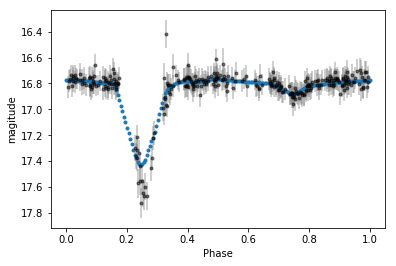

In [22]:
from supersmoother import SuperSmoother
model = SuperSmoother(alpha=5, period=1)
model.fit(phase, mag, dmag)
g_len = 200
x_fit = numpy.linspace(0, 1, g_len)
y_fit = model.predict(x_fit)
x_fit  = (x_fit + x_fit[int(g_len/4)] - x_fit[numpy.argmax(y_fit)]) %1
phase = (phase + x_fit[int(g_len/4)] - x_fit[numpy.argmax(y_fit)]) %1

fig, ax = plt.subplots()
ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
ax.plot(numpy.linspace(0, 1, g_len), y_fit[numpy.argsort(x_fit)], '.', lw = 5 ,)

ax.set(xlabel='Phase', ylabel='magitude')
ax.invert_yaxis();

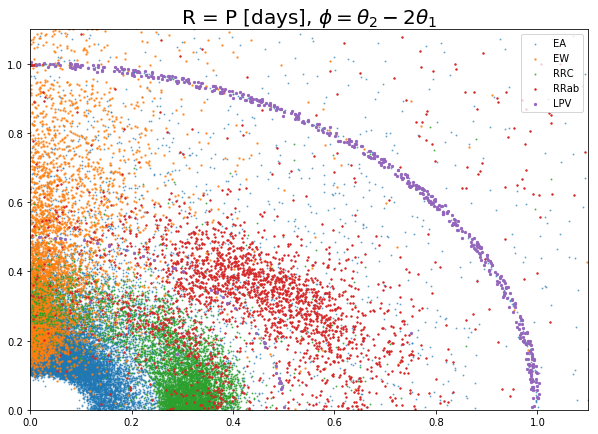

In [10]:
plt.figure(figsize = (10,7))
plt.title(r'R = P [days], $\phi = \theta_2 - 2\theta_1$', fontsize = 20)

x = p*numpy.abs(numpy.cos( X_h[:,2]  ))
y = p*numpy.abs(numpy.sin(X_h[:,2] ))

inds = numpy.where(lbls_all == 1)[0]
plt.scatter(x[inds], y[inds], s = 1, alpha = 0.5, label = 'EA')

inds = numpy.where(lbls_all == 2)[0]
plt.scatter(x[inds], y[inds], s = 2, alpha = 0.7, label = 'EW')

inds = numpy.where(lbls_all == 5)[0]
plt.scatter(x[inds], y[inds], s = 1, alpha = 0.7, label = 'RRC')



inds = numpy.where(lbls_all == 4)[0]
plt.scatter(x[inds], y[inds], s = 2, label = 'RRab')

inds = numpy.where(lbls_all == 13)[0]
plt.scatter(x[inds], y[inds], s = 5, label = 'LPV')


plt.legend()
l = 1.1
plt.xlim([0,l])
plt.ylim([0,l])
plt.show()

In [16]:
# This file runs the supersmoother, the output is on a phase grid (use %run to run it)
!cat fit_supersmoother.py

from supersmoother import SuperSmoother
import numpy
from tqdm import trange

lc_list = numpy.load('lc_list.npy')
periods_arr = numpy.load('periods_arr.npy')


grid_len = 200
p_loc = int(grid_len/4)
x_fit = numpy.linspace(0, 1, grid_len)

n_objects = len(lc_list)
X_supersmoother = numpy.zeros([n_objects, grid_len])

for i in trange(n_objects):
    
    lc = lc_list[i]
    mag = lc[:,0]
    dmag = lc[:,2]
    t = lc[:,1]
    period = periods_arr[i]
    phase = (t /period /2) % 1
    
    model = SuperSmoother(alpha=5, period=1)
    model.fit(phase, mag, dmag)
    y_fit = model.predict(x_fit)
    
    grid_order = (x_fit + x_fit[p_loc] - x_fit[numpy.argmax(y_fit)]) %1
    y_fit = y_fit[numpy.argsort(grid_order)]
    
    X_supersmoother[i] = y_fit

numpy.save('X_supersmoother', X_supersmoother)

In [17]:
# This file puts the supersmoother output on a time grid  (use %run to run it)
!cat preproc_supersmoother.py

import numpy
from scipy.interpolate import interp1d
from tqdm import trange

X_supersmoother = numpy.load('X_supersmoother.npy')

periods_arr = numpy.load('periods_arr.npy')

n_objects = X_supersmoother.shape[0]
n_features_orig = X_supersmoother.shape[1]

n_features = 1000
grid_all = numpy.linspace(0,2,n_features) #days
n_p = 20

X_supersmoother_same_grid = numpy.zeros([n_objects, n_features])

for i in trange(n_objects):
    period = periods_arr[i]
    
    o_grid = numpy.linspace(0,1,n_features_orig*n_p)*n_p*period*2
    y_dup = numpy.concatenate([X_supersmoother[i]]*n_p)
    f_intr = interp1d(x=o_grid, y=y_dup)
    
    X_supersmoother_same_grid[i] = f_intr(grid_all)
    X_supersmoother_same_grid[i] = X_supersmoother_same_grid[i] - numpy.mean(X_supersmoother_same_grid[i]) 
    #X_supersmoother_same_grid[i] = X_supersmoother_same_grid[i] / numpy.std(X_supersmoother_same_grid[i])
    
numpy.save('X_supersmoother_same_grid_v2', X_supersmoother_same_grid)

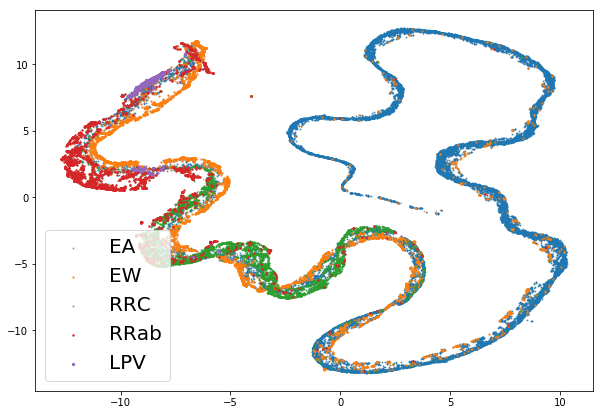

In [15]:
umap_results = numpy.load('umap_results_v4/umap_result_nn_5_md_0.01.npy')

x = umap_results[:, 0]
y = umap_results[:, 1]
plt.figure(figsize = (10,7))
#plt.title('nn={}, md={}'.format(nn, md))

plt.scatter(x, y, s=0.1, c='gray')

inds = numpy.where(lbls_all == 1)[0]
plt.scatter(x[inds], y[inds], s = 1, alpha = 0.5, label = 'EA')

inds = numpy.where(lbls_all == 2)[0]
plt.scatter(x[inds], y[inds], s = 2, alpha = 0.7, label = 'EW')

inds = numpy.where(lbls_all == 5)[0]
plt.scatter(x[inds], y[inds], s = 1, alpha = 0.7, label = 'RRC')



inds = numpy.where(lbls_all == 4)[0]
plt.scatter(x[inds], y[inds], s = 2, label = 'RRab')

inds = numpy.where(lbls_all == 13)[0]
plt.scatter(x[inds], y[inds], s = 5, label = 'LPV')

plt.legend(fontsize = 20)
#plt.axis('off')
#plt.xlim(get_plot_limit(x))
#plt.ylim(get_plot_limit(y))
plt.show()

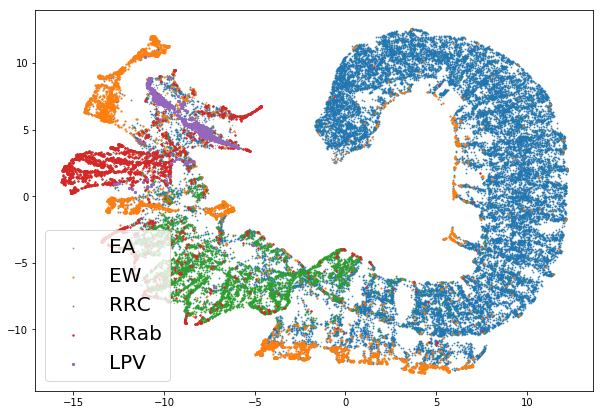

In [21]:
umap_results = numpy.load('umap_results_v6/umap_result_nn_50_md_0.25.npy')

x = umap_results[:, 0]
y = umap_results[:, 1]
plt.figure(figsize = (10,7))
#plt.title('nn={}, md={}'.format(nn, md))

plt.scatter(x, y, s=0.1, c='gray')

inds = numpy.where(lbls_all == 1)[0]
plt.scatter(x[inds], y[inds], s = 1, alpha = 0.5, label = 'EA')

inds = numpy.where(lbls_all == 2)[0]
plt.scatter(x[inds], y[inds], s = 2, alpha = 0.7, label = 'EW')

inds = numpy.where(lbls_all == 5)[0]
plt.scatter(x[inds], y[inds], s = 1, alpha = 0.7, label = 'RRC')



inds = numpy.where(lbls_all == 4)[0]
plt.scatter(x[inds], y[inds], s = 2, label = 'RRab')

inds = numpy.where(lbls_all == 13)[0]
plt.scatter(x[inds], y[inds], s = 5, label = 'LPV')

plt.legend(fontsize = 20)
#plt.axis('off')
#plt.xlim(get_plot_limit(x))
#plt.ylim(get_plot_limit(y))
plt.show()